In [1]:
## Importing libraries
import time
import warnings

import eli5

warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")
%matplotlib inline


import optuna
from optuna.integration import LightGBMPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

import plotly.express as px
from catboost import CatBoostRegressor, Pool
from lightgbm import DaskLGBMRegressor, LGBMRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler
from xgboost import DMatrix, XGBRegressor

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
!pwd

/home/balde/Desktop/Python/ELP


## Reading the data

In [3]:
train = pd.read_csv("Train.csv")

test = pd.read_csv("Test.csv")
sub = pd.read_csv("SampleSubmission (1).csv")
vard = pd.read_csv("VariableDescription.csv")

In [4]:
train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,...,obs_cooking_5,obs_cooking_6,obs_heating_1,obs_heating_2,obs_heating_3,obs_heating_4,obs_heating_5,obs_heating_6,obs_heating_7,target
0,ID_SYSJ2FM0D,2022.0,2022-02-03,59.000000,NaN,NaN,NaN,NaN,NaN,Sometimes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
1,ID_J5BTFOZR3,2019.0,NaN,60.163933,NaN,NaN,NaN,1st year in the programme,103.000000,Sometimes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.869999
2,ID_R00SN7AUD,2022.0,2022-03-11,69.000000,NaN,NaN,NaN,NaN,108.400002,Often,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.520000
3,ID_BSSK60PAZ,2021.0,2021-10-13,53.000000,2020-01-15,20.0,No,1st year in the programme,98.099998,Almost always,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.599998
4,ID_IZTY6TC4D,2021.0,2021-10-13,57.000000,2021-10-13,0.0,NaN,2nd year in programme,114.000000,Almost always,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,76.599998


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8585 entries, 0 to 8584
Columns: 679 entries, child_id to target
dtypes: float64(160), object(519)
memory usage: 44.5+ MB


In [6]:
df_train = train.copy()
df_test = test.copy()

In [7]:
# train.columns[train.columns.str.contains("observe")].to_list()
observe_columns = [
    "child_observe_attentive",
    "child_observe_concentrated",
    "child_observe_diligent",
    "child_observe_interested",
]

mapper_observe = {"Sometimes": 1, "Almost never": 0, "Often": 2, "Almost always": 3}

In [8]:
social_columns = [
    "teacher_social_initiative",
    "teacher_social_peers",
    "teacher_social_nonaggressive",
    "teacher_social_cooperate",
    "teacher_social_assistance",
    "teacher_social_ideas",
    "teacher_social_initiative",
]

mapper_social = {
    "None of the time": 0,
    "A little of the time": 1,
    "Most of the time": 2,
    "All of the time": 3,
}

In [9]:
# Function to map values to the columns
def mapper(df, map_columns, map_values):
    for col in map_columns:
        df[col] = df[col].map(map_values)
    return df

In [10]:
# Mapping values
df_train = mapper(df_train, observe_columns, mapper_observe)
df_test = mapper(df_test, observe_columns, mapper_observe)

df_train = mapper(df_train, social_columns, mapper_social)
df_test = mapper(df_test, social_columns, mapper_social)

In [11]:
df_train.columns[df_train.columns.str.contains("child")]

Index(['child_id', 'child_date', 'child_age', 'child_enrolment_date',
       'child_months_enrolment', 'child_grant', 'child_years_in_programme',
       'child_height', 'child_observe_attentive', 'child_observe_concentrated',
       'child_observe_diligent', 'child_observe_interested',
       'child_observe_total', 'child_gender', 'child_dob', 'child_zha',
       'child_stunted', 'child_attends', 'child_attendance', 'child_languages',
       'child_age_group', 'pri_children_4_6_years', 'obs_toilets_children',
       'count_children_present', 'count_children_attendance',
       'count_children_precovid', 'count_toilets_children', 'language_child'],
      dtype='object')

In [12]:
# map_years = {'1st year in the programme': 1,
#              '2nd year in programme': 2,
#              '3rd year in programme': 3,
#              'Do Not Know':0}

# df_train["child_years_in_programme"] = df_train["child_years_in_programme"].map(map_years)
# df_test["child_years_in_programme"] = df_test["child_years_in_programme"].map(map_years)

In [13]:
drop_cols = [
    "count_staff_gender_other",
    "pri_days",
    "obs_lighting_8",
    "count_practitioners_all",
    "count_register_gender_other",
    "obs_heating_3",
    "obs_lighting_5",
    "pri_difficult_see",
    "pri_difficult_walk",
    "obs_lighting_6",
    "teacher_social_initiative",
]
df_train[drop_cols].isnull().sum()

count_staff_gender_other       3424
pri_days                       3394
obs_lighting_8                 6330
count_practitioners_all        6957
count_register_gender_other    3470
obs_heating_3                  6324
obs_lighting_5                 6330
pri_difficult_see              6957
pri_difficult_walk             6957
obs_lighting_6                 6330
teacher_social_initiative      8585
dtype: int64

In [14]:
len(df_train.query("child_gender == 'Female'"))

4442

In [15]:
# df_train["child_gender"] = df_child["child_gender"].map({"Male": })

In [16]:
# pd.set_option("display.max_rows", 50)
# df_train["child_dob"] =
# df_train["child_dob"] = pd.to_datetime(df_train["child_dob"],yearfirst=True)
# df_test["child_dob"] = pd.to_datetime(df_test["child_dob"],yearfirst=True)

# df_train["child_dob_month"] = df_train["child_dob"].dt.month
# df_test["child_dob_month"] = df_test["child_dob"].dt.month

# Machine Learning Algorithms

## Training with numerical columns only

In [17]:
n_splits = 10

kf = KFold(n_splits, shuffle=True, random_state=42)
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=42)

In [18]:
# # Cross validation
def cross_validation(X, y, model, cv_method):
    rmse_scores = list()

    # cv = cv_method(n_splits = N_SPLITS, n_repeats=5, random_state=1121218)

    for idx, (train_idx, test_idx) in enumerate(cv_method.split(X, y)):

        print("=" * 12 + f"Training fold {idx}" + 12 * "=")
        start = time.time()

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Making eval_set
        eval_set = [(X_test.values, y_test)]

        # Fitting the model to the data
        model.fit(X_train.values, y_train)

        # Predictions
        preds = model.predict(X_test)

        # Loss
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_scores.append(rmse)

        runtime = time.time() - start

        print(f"Fold {idx} finished with score: {rmse:.5f} in {runtime:.2f} seconds.\n")

    print(f"Average score {np.mean(rmse_scores)}")

    return np.mean(rmse_scores), rmse_scores


# rmse, cv_scores = cross_validation(X, y, hgbr, k_fold)

In [19]:
# Getting feature importances
def get_feature_imp(model, imp_factor):
    cols_imp = [
        (col, imp)
        for col, imp in zip(model.feature_name_, model.feature_importances_)
        if imp < imp_factor
    ]
    cols = [
        col
        for col, imp in zip(model.feature_name_, model.feature_importances_)
        if imp < imp_factor
    ]

    return cols, cols_imp

In [20]:
def feature_imp_dataframe(model):
    feature_imp = model.feature_importances_
    columns = model.feature_name_

    df_imp = pd.DataFrame({"features": columns, "feature_importance": feature_imp})

    df_imp.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    df_imp.reset_index(drop=True, inplace=True)

    return df_imp

In [21]:
def plot_feature_importance(df_feature_imp, n_imp_cols):
    labels = df_feature_imp.iloc[:30, 0].values

    plt.figure(figsize=(20, 6))
    ax = df_feature_imp.iloc[:30, 1].plot(kind="bar", title="Feature Importance")
    ax.set_xticklabels(labels)
    plt.show()

### Selecting numerical columns from df_train and df_test

### Lightgbm

In [22]:
cols_list_2 = [
    "pri_difficult_see",
    "count_staff_contract_substitute",
    "pri_difficult_walk",
    "obs_lighting_4",
    "obs_heating_3",
    "count_register_gender_other",
    "count_staff_paid_managers",
    "obs_lighting_5",
    "count_practitioners_all",
    "obs_cooking_4",
    "pri_days",
    "count_staff_gender_other",
    "obs_cooking_5",
    "obs_lighting_6",
    "obs_lighting_3",
]

cols_list_3 = [
    "pri_difficult_see",
    "count_staff_contract_substitute",
    "pri_difficult_walk",
    "obs_lighting_4",
    "obs_heating_3",
    "count_register_gender_other",
    "count_staff_paid_managers",
    "obs_lighting_5",
    "count_practitioners_all",
    "obs_cooking_4",
    "pri_days",
    "count_staff_gender_other",
    "obs_cooking_5",
    "obs_lighting_6",
    "obs_lighting_3",
    "language_match",
    "teacher_social_initiative",
    "obs_lighting_8",
    "obs_heating_7",
]

In [23]:
train_int_cols = df_train.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns
test_int_cols = df_test.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns

# Numerical columns
num_cols = list(set(test_int_cols).intersection(set(train_int_cols)))


X, y = df_train[num_cols].drop(columns=drop_cols), df_train[["target"]]
# X, y = df_train[num_cols].drop(columns=cols_list_2), df_train[['target']]
# X, y = df_train[num_cols].drop(columns=cols_list_3), df_train[['target']]

# Selecting the features for test-data
# Prediction on test set
test_data = df_test[X.columns.to_list()]

In [24]:
X.shape, y.shape

((8585, 158), (8585, 1))

In [25]:
X.head()

,obs_heating_2,id_prov_n,count_children_precovid,count_staff_salary_paid,count_present_girls,pri_difficult_learn,count_practitioners_age_5,count_practitioners_age_1,pra_class_size,count_register_year_2019,...,pri_amount_funding_dsd,quintile,child_observe_diligent,obs_lighting_1,count_staff_paid_maintenance,pri_year,obs_heating_6,count_staff_gender_male,count_register_all,pri_fees_amount_4_6
0,NaN,1051.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,38.0,NaN
1,NaN,1832.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3214.0,38.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1,NaN,NaN,2014.0,NaN,2.0,38.0,NaN
4,0.0,1832.0,30.0,0.0,9.0,0.0,1.0,0.0,12.0,7.0,...,NaN,1.0,3,1.0,NaN,2017.0,0.0,0.0,27.0,NaN


# Capturing NaN per row and making a new feature

In [26]:
def feature_engineering(df):
    df["NaN_row"] = df.isna().sum(axis=1)
    df["std"] = df.std(axis=1)
    return df


X = feature_engineering(X)
test_data = feature_engineering(test_data)

# Filling missing values

In [27]:
pipeline = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", MinMaxScaler())
        # ('quantiletransform', QuantileTransformer(random_state=seed))
    ]
)

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
test_data = pd.DataFrame(columns=test_data.columns, data=pipeline.transform(test_data))

In [28]:
X.head()

,obs_heating_2,id_prov_n,count_children_precovid,count_staff_salary_paid,count_present_girls,pri_difficult_learn,count_practitioners_age_5,count_practitioners_age_1,pra_class_size,count_register_year_2019,...,child_observe_diligent,obs_lighting_1,count_staff_paid_maintenance,pri_year,obs_heating_6,count_staff_gender_male,count_register_all,pri_fees_amount_4_6,NaN_row,std
0,0.643078,0.327007,0.225392,0.148433,0.168898,0.033976,0.078457,0.120188,0.308058,0.083479,...,0.333333,0.110865,0.191033,0.776840,0.026095,0.075362,0.129693,0.14619,0.896552,0.825559
1,0.643078,0.570006,0.225392,0.148433,0.168898,0.033976,0.078457,0.120188,0.308058,0.083479,...,0.333333,0.110865,0.191033,0.776840,0.026095,0.075362,0.196023,0.14619,0.931034,0.000009
2,0.643078,1.000000,0.225392,0.148433,0.168898,0.033976,0.078457,0.120188,0.308058,0.083479,...,0.333333,0.110865,0.191033,0.776840,0.026095,0.075362,0.196023,0.14619,0.834483,0.182199
3,0.643078,1.000000,0.126246,0.102564,0.168898,0.033976,0.078457,0.120188,0.308058,0.083479,...,0.333333,0.110865,0.191033,0.917647,0.026095,0.250000,0.129693,0.14619,0.579310,0.067352
4,0.000000,0.570006,0.099668,0.000000,0.075000,0.000000,0.090909,0.000000,0.116667,0.093333,...,1.000000,1.000000,0.191033,0.952941,0.000000,0.000000,0.092150,0.14619,0.082759,0.246091


In [29]:
(X.var()[:-50])

obs_heating_2                 0.060457
id_prov_n                     0.067083
count_children_precovid       0.012479
count_staff_salary_paid       0.005256
count_present_girls           0.003625
                                ...   
count_staff_qual_nqf6_9       0.004304
count_register_year_2013      0.000490
count_register_year_grader    0.006448
count_toilets_adults          0.004154
count_staff_salary_unpaid     0.008163
Length: 110, dtype: float64

In [30]:
params = {
    "learning_rate": 0.02,
    # "objective": "regression",
    "objective": "poisson",
    "n_estimators": 4000,
    "num_leaves": 35,
    "max_bin": 240,
    "colsample_bytree": 0.3,
    "max_depth": 5,
    "min_child_samples": 20,
    "random_state": 42,
}

In [31]:
best_trial = {
    "n_estimators": 54884,
    "reg_alpha": 1.511619688143909,
    "reg_lambda": 0.46134859372486536,
    "colsample_bytree": 0.3,
    "subsample": 1.0,
    "learning_rate": 0.02,
    "max_depth": 20,
    "num_leaves": 16,
    "min_child_samples": 21,
    "min_data_per_groups": 48,
}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=55
)

# Training the model with reduced columns
lgbm = LGBMRegressor(**params)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    early_stopping_rounds=100,
    verbose=False,
)

# Get score
lgbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 9.581407128785791),
                          ('poisson', -140.729681442704)])})

In [33]:
get_feature_imp(lgbm, 5)

([], [])

In [34]:
# Training the model on whole dataset
lgbm = LGBMRegressor(**params)
lgbm.fit(X, y)

LGBMRegressor(colsample_bytree=0.3, learning_rate=0.02, max_bin=240,
              max_depth=5, n_estimators=4000, num_leaves=35,
              objective='poisson', random_state=42)

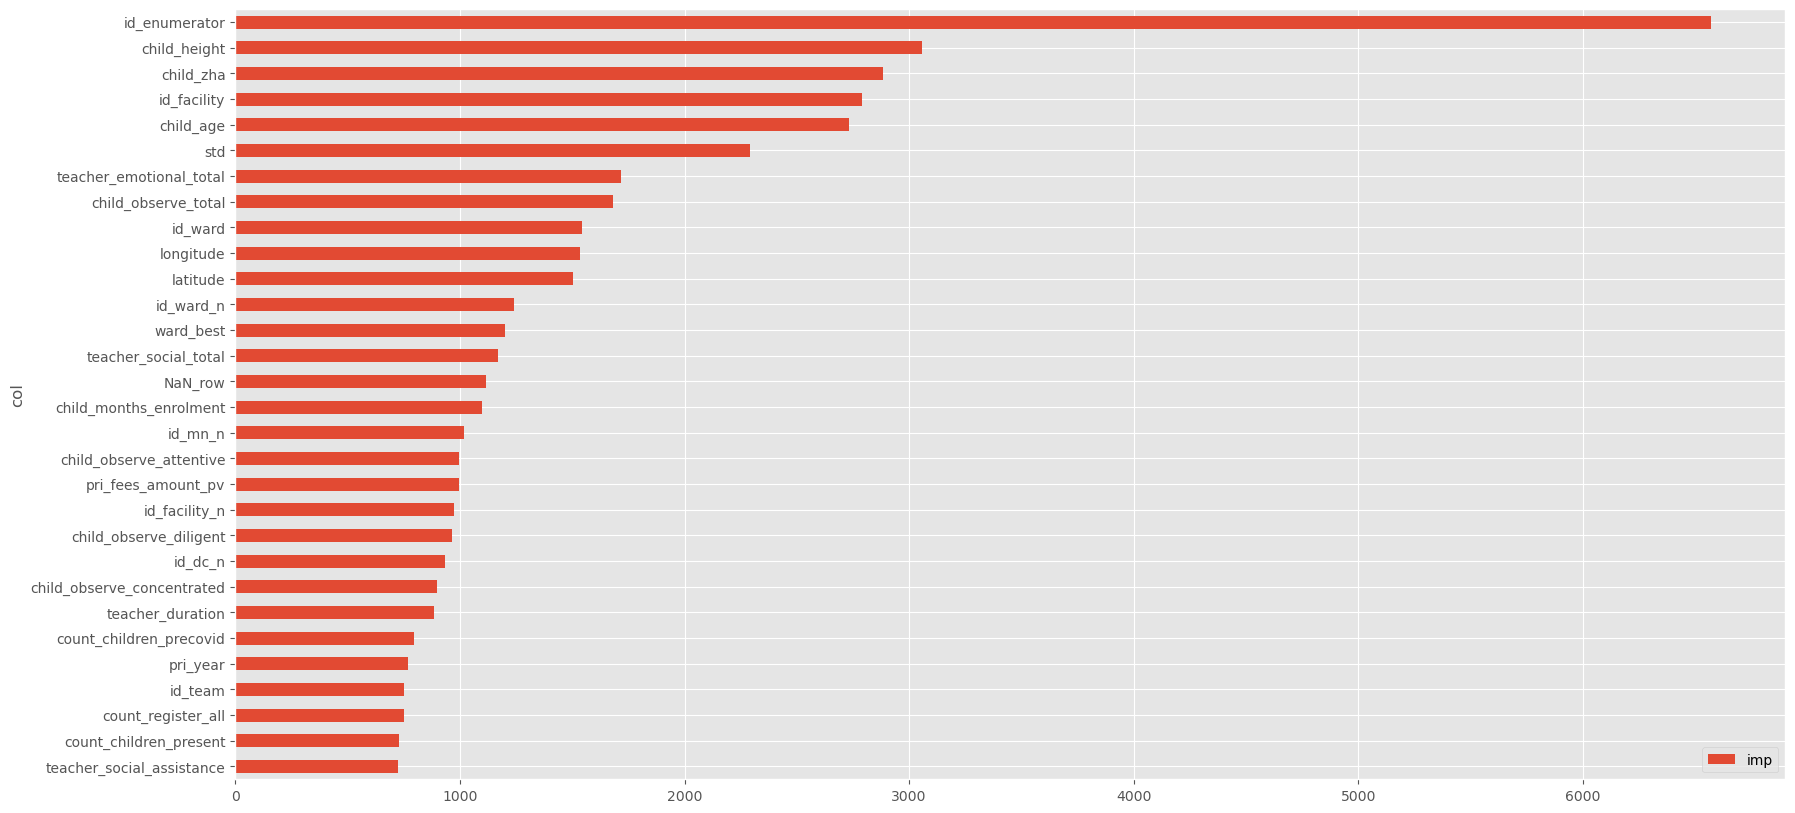

In [35]:
fea_imp = pd.DataFrame({"imp": lgbm.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=True).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [36]:
# Prediction on test set
# test_data = df_test[X.columns.to_list()]

preds = lgbm.predict(test_data)
preds

array([61.28514863, 47.947684  , 48.70122538, ..., 42.97650099,
       38.61036877, 43.66461582])

In [37]:
# Creating a submissionfile
sub_file = pd.read_csv("GBRSubmission1_score_10.63.csv")
sub_file.target = preds
sub_file.to_csv("LGBMSubmission.csv", index=False)

In [38]:
kjkjkd

NameError: name 'kjkjkd' is not defined

In [ ]:
import optuna
from sklearn.model_selection import train_test_split


def objective(trial, data=X, target=y):

    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.2, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": 42,
        # "n_estimators": 20000,
        "n_estimators": trial.suggest_int("n_estimators", 100, 100_000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.001, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04, 0.05]
        ),
        "max_depth": trial.suggest_categorical(
            "max_depth",
            [
                6,
                7,
                8,
                8,
                10,
                11,
                13,
                14,
                15,
                20,
            ],
        ),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("min_data_per_groups", 1, 100),
    }
    model = LGBMRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)